In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Motion Detection
### Difference Between Frames Algorithm
- Movement is the difference between two frames
- Difference has noises, because of details, and lights
- So gaussian blurring is used to eliminate these noises
- then Obtaining threshold of differences (to get high difference only)
- then dilating for eliminating small weak threshold lines
- then finding contours from the cleaned threshold
- eliminate small contours
- drawing rectangles for each detected contour on the frame

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

cap = cv2.VideoCapture('Videos/people_walking_sample.mp4')
# cap = cv2.VideoCapture(0)

frame_width = int(cap.get(3))   # 1280
frame_height = int(cap.get(4))  # 720

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Output.avi', fourcc, 20, (frame_width, frame_height))

ret, frame1 = cap.read()  # first frame
ret, frame2 = cap.read()  # second frame.. will apply later on it

font = cv2.FONT_HERSHEY_SIMPLEX

while cap.isOpened():
    if ret == True:
        # difference between two consecutive frames
        diff = cv2.absdiff(frame1, frame2)  
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

        # Remove Noise due to lights difference
        blur = cv2.GaussianBlur(gray, (5,5), 0)

        # Converting difference to Binary (Thresholding)
        _, thresh = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY)

        # Getting strong differences only
        dilated = cv2.dilate(thresh, None, iterations=10)

        # Finding Contours of differents
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Draw Rectangle for each Contour
        for contour in contours:
            (x,y,w,h) = cv2.boundingRect(contour) # Getting Dimension of each rectangle

            # Detecting Large Area Contours (People)
            if cv2.contourArea(contour) > 2000:
                cv2.rectangle(frame1, (x,y), (x+w, y+h), (0,255,0), 5)
                cv2.putText(frame1, "Status: Movement", (10,20), font, 1, (0,0,255), 3)

        cv2.imshow("Motion Detector", frame1)
        cv2.imshow("Threshold", thresh)
        cv2.imshow("dilated", dilated)

        # Saving Video of Tracked       
        image = cv2.resize(frame1, (1280,720))
        out.write(image)

        # To make two different frames
        frame1 = frame2
        ret, frame2 = cap.read()

        # Waiting to close
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break

cv2.destroyAllWindows()
cap.release()
out.release()


### Background Subtractor(MOG) Object Detection (Algorithm for Stable Camera)
#### And TRACKING

Background Subtractor Algorithm (Required to make background black and moving objects white)

- Will be very bad if camera moved
- This is simple algorithm !! not very accurate

In [ ]:
import cv2
from tracker import *     # I Edited the file in the users/ahmed/anaconda3....

font = cv2.FONT_HERSHEY_SIMPLEX

# Algorithm to track
tracker = EuclideanDistTracker()

# Algorithm to Detect from Stable Camera (This Subtract Background from foreground)
object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=90)


# Opening Video
cap = cv2.VideoCapture('Videos/people_walking_sample.mp4')


while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
    
        # Focusing on a part of area of video
        # roi = frame[340:720, 500:800]
        roi = frame

        # Object Detection
        mask = object_detector.apply(roi)
        
        # Threshold on Mask To remove Shadow
        _, mask = cv2.threshold(mask, 254,255, cv2.THRESH_BINARY)
        
        # Dilate
        mask = cv2.dilate(mask, None, iterations=7)
        
        # Making Contours
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Draw Rectangle for each Contour
        detections = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 1000 and area < 7000:
                (x,y,w,h) = cv2.boundingRect(contour) # Getting Dimension of each rectangle
                detections.append([x,y,w,h])

#             # Detecting Large Area Contours (People)
#             if cv2.contourArea(contour) > 1000:
#                 cv2.rectangle(roi, (x,y), (x+w, y+h), (0,255,0), 5)
#                 cv2.putText(frame, "Status: Movement", (10,20), font, 1, (0,0,255), 3)


        # Object Tracking
        boxes_ids = tracker.update(detections)
        for box_id in boxes_ids:
            x,y,w,h, id = box_id
            cv2.putText(roi, str(id), (x,y), font, 1, (0,0,255), 3)
            cv2.rectangle(roi, (x,y), (x+w, y+h), (0,255,0), 5)
            
            
        # Showing mask
        cv2.imshow("Mask", mask)
        cv2.imshow("Frame", frame)
        
        # Waiting to close
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()

### BackGroundSubtractor (MOG) Advanced
#### And Counting Number of Vehicles Passed a Line

In [ ]:
import cv2
import numpy as np
font = cv2.FONT_HERSHEY_SIMPLEX

# Function to return center of object contour
def object_center(x,y,w,h):
    x1 = int(w/2)
    y1 = int(h/2)
    cx = x+x1
    cy = y+y1
    
    return cx, cy

# List to append Number of Detected Objects
detected = []
counter = 0
min_width_object = 30
min_height_object = 70

# Line Passing Y
y_line = 270
offset = 6

cap = cv2.VideoCapture('Videos/people_walking_sample.mp4')

# Detector Algorithm
BGS = cv2.bgsegm.createBackgroundSubtractorMOG()

while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # To be easier to remove noise
        blur = cv2.GaussianBlur(gray, (3,3), 5)
        
        # Applying BGS
        mask = BGS.apply(blur)
        dilate = cv2.dilate(mask, np.ones((5,5)))
        
        # Finding Contours
        contours, _ = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        
        # Drawing a Line, so we count cars when it passes through that line
        cv2.line(frame, (25,y_line), (1200, y_line), (176,130,39), 5)
        
        # Processing and counting Objects
        for i, cnt in enumerate(contours):
            (x,y,w,h) = cv2.boundingRect(cnt)
            # Detection of suitable width and length (to count all people)
            valid_object = (w >= min_width_object) and (h >= min_height_object)
            if valid_object:
                cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 5)
                # Center of contour
                center = object_center(x,y,w,h) 
                detected.append(center)
                cv2.circle(frame, center, 4, (0,0,255), -1) # Circle on Center
        
        # Counting Objects
        for (x,y) in detected:
            if (y < (y_line + offset)) and (y > (y_line - offset)):
                counter+=1
                cv2.line(frame, (25,y_line), (1200, y_line), (255,255,0), 5)
                detected.remove((x,y))
                
                
                
                
            
            
        cv2.putText(frame, 'OBJECTs Count:' + str(counter), (10,15), font, 1, (0,0,255), 3)
        # Showing the frames
        cv2.imshow("Frame", frame)
        
        # Waiting to close
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()

## YOLOv3 Detection

### Configuring Net Model and Detection Configurations

In [4]:
import cv2
# import csv
# import collections
import numpy as np
from tracker import *

# Default Font
font = cv2.FONT_HERSHEY_SIMPLEX

# Initialize Tracker
tracker = EuclideanDistTracker()

# Detection confidence threshold
confThreshold = 0.1   # Confidence of classification
nmsThreshold = 0.2    # confidence of bounding box intersection

# Cross Line 
middle_line_position = 225   
up_line_position = middle_line_position - 15
down_line_position = middle_line_position + 15

# Coco Names (for YOLOv3)
classFile = 'YOLO/coco.names'
classNames = open(classFile).read().strip().split('\n')
# print(classNames)
# print(len(classNames))  # 80 object

# Model File
modelConfiguration = 'YOLO/yolov3-320.cfg'
modelWeights = 'YOLO/yolov3-320.weights'
# Configure Network Model
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

# Using GPU --> if not Comment These lines
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)   
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Define random Color for each class
np.random.seed(42)
colors = np.random.randint(0,255, size = (len(classNames),3), dtype='uint8')

# Detected And Required Classes to detect
detected_classNames = []
required_class_index = [0,2]     # From coco (Person, car)


# List for store object count information (Moving up and Moving down)
temp_up_list = []
temp_down_list = []
# Temp lists
up_list = [0, 0]            # Number of zeros is the number of objects to detect
down_list = [0, 0]

### Helper Functions

#### Processing the Network

In [5]:
def process_network(frame):
    # The input of YOLOv3 frames is 320x320
    input_size = 320

    # Resizing the image and Normalizing it
    blob = cv2.dnn.blobFromImage(frame, 1/255, (input_size, input_size), [0,0,0], 1, crop=False)

    # Setting the input of the net
    net.setInput(blob)
    layersNames = net.getLayerNames()
    outputNames = [(layersNames[i - 1]) for i in net.getUnconnectedOutLayers()]   # For CUDA in Python 3.9
    # outputNames = [(layersNames[i[0] - 1]) for i in net.getUnconnectedOutLayers()]   # For non CUDA in Python 3.7


    # Feed data to network (outputs contains 3 vectors[bounding box, box confidence, 80 class confidence])
    outputs = net.forward(outputNames)
    return outputs

#### Processing the Output
- The output layer of YOLOv3 for one frame is 3 outputs
- each output contains huge number of vectors
- each vector in each output contains 85 values
- **The First four values represent bounding box (x,y,w,h)**
- **The fifth value represent the Confidence Score**
- **The remaining 80 values represent the probability of each class**

In [6]:
def postProcess(outputs, img):
    global detected_classNames
    height, width = img.shape[:2]
    
    boxes = []
    classIds = []
    confidence_scores = []
    detections = []
    
    
    for output in outputs:
        for det in output:
            scores = det[5:]                 # Scores of each class (from 5 to 85)
            classId = np.argmax(scores)      # Maximum score
            confidence = scores[classId]     # Confidence of class
            
            # Check if the object we require to detect
            if classId in required_class_index:
                if confidence > confThreshold:
                    w,h = int(det[2] * width), int(det[3] * height)
                    x,y = int((det[0] * width) - w/2), int((det[1] * height) - h/2)
                    
                    boxes.append([x,y,w,h])
                    classIds.append(classId)
                    confidence_scores.append(float(confidence))
                    
    # Apply Non-Max Supression ( Remove multiple bounding boxes for an object)
    indices = cv2.dnn.NMSBoxes(boxes, confidence_scores, confThreshold, nmsThreshold)
    
    for i in indices.flatten():
        x,y,w,h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
        color = [int(c) for c in colors[classIds[i]]]
        name = classNames[classIds[i]]
        detected_classNames.append(name)
        
        # Put text
        text = name.upper() + "{:.2f}".format(confidence_scores[i]*100)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, text, (x,y-10), font, 0.5, color, 1)
        
        # Draw Bounding Box
        cv2.rectangle(img, (x,y), (x+w, y+h), color, 1)
        
        # Adding to Detection
        detections.append([x,y,w,h,required_class_index.index(classIds[i])])
        
    # Tracking Objects
    boxes_ids = tracker.update(detections)
    for box_id in boxes_ids:
        count_object(img, box_id)

#### Count Object Function for Tracking

In [7]:
# Function to return center of object
def find_center(x,y,w,h):
    x1 = int(w/2)
    y1 = int(h/2)
    cx = x+x1
    cy = y+y1
    
    return cx, cy


# Function for count object
def count_object(img, box_id):
    x, y, w, h, id, index = box_id
    
    # Find the center of the rectangle for detection
    center = find_center(x, y, w, h)
    ix, iy = center
    
    # Check if it's moving up or down
    if (iy > up_line_position) and (iy < middle_line_position):
        if id not in temp_up_list:
            temp_up_list.append(id)
    elif iy < down_line_position and iy > middle_line_position:
        if id not in temp_down_list:
            temp_down_list.append(id)
            
    elif iy < up_line_position:
        if id in temp_down_list:
            temp_down_list.remove(id)
            up_list[index] = up_list[index]+1
    elif iy > down_line_position:
        if id in temp_up_list:
            temp_up_list.remove(id)
            down_list[index] = down_list[index] + 1
            
    # Adding Texts        
    cv2.putText(img, "Up", (110, 20), font, 1, (0,255,255), 1)
    cv2.putText(img, "Down", (160, 20), font, 1, (0,255,255), 1)
    cv2.putText(img, "Person:   " + str(up_list[0]) + "     " + str(down_list[0]), (20, 40), font, 1, (0,0,255), 2)
    cv2.putText(img, "Car:      " + str(up_list[1]) + "     " + str(down_list[1]), (20, 60), font, 1, (0,0,255), 2)

### Reading the Video File

In [8]:
cap = cv2.VideoCapture('Videos/people_walking_sample.mp4')
# cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
#         frame = cv2.resize(frame, (0,0), None, 0.5, 0.5)  # Reducing Fps
        ih, iw, ch = frame.shape
        
        # Draw Crossing Line
        cv2.line(frame, (0, middle_line_position), (iw, middle_line_position), (255, 0, 255), 1)
        cv2.line(frame, (0, up_line_position), (iw, up_line_position), (0, 0, 255), 1)
        cv2.line(frame, (0, down_line_position), (iw, down_line_position), (0, 0, 255), 1)  
        
        # Processing Network and returning outputs
        outputs = process_network(frame)
        
        # Processing Frames and detection
        postProcess(outputs, frame)
        
        # Showing Output
        cv2.imshow('Output', frame)
        
        # Waiting to close
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()

## Haar Cascade Detection

### Frontal Face Detection Haarcascade
- Not very accurate, Requires full front face

In [5]:
face_cascade = cv2.CascadeClassifier('Haarcascade/haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, img = cap.read()
    if ret == True:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        for(x,y,w,h) in faces:
            cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 3)
            
        cv2.imshow('img', img)
        
        # Waiting to close
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()
        

### Eye Detection Haarcascade

In [30]:
face_cascade = cv2.CascadeClassifier('Haarcascade/haarcascade_frontalface_default.xml')
eye_cascade  = cv2.CascadeClassifier('Haarcascade/haarcascade_eye_tree_eyeglasses.xml')

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, img = cap.read()
    if ret == True:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        # Face Detection
        for (x,y,w,h) in faces:
            cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 3)
            cv2.putText(img, "Face", (x,y-4), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
            # Eye Detection
            eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
            for(ex, ey, ew, eh) in eyes:
                cv2.rectangle(img, (ex,ey), (ex+ew, ey+eh), (0,255,0), 5)
                cv2.putText(img, "Eye", (ex,ey-3), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        
        cv2.imshow('img',img)
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()
        

## Face Detection Using dlib
- Detecting 68 Landmarks on the face

In [ ]:
import dlib     # Must be installed on Python 3.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks')

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, img = cap.read()
    if ret == True:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detecting Faces
        faces = detector(gray)
        
        for face in faces:
            x1 = face.left()
            y1 = face.top()
            x2 = face.right()
            y2 = face.bottom()
            
            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)
            
            # To Draw Landmarks
            landmarks = predictor(gray, face)
            for n in range(68):
                x_loc = landmarks.part(n).x
                y_loc = landmarks.part(n).y
                # Draw Circle on Landmarks
                cv2.circle(img, (x_loc, y_loc), 3, (0,255,0), -1)
                
        cv2.imshow('img', img)
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()
        

## Face Mesh Detection (mediapipe)
- 468 Points

In [29]:
import mediapipe as mp
import cv2
import numpy as np

# Getting Face Mesh Algorithm
# Works on RGB images
mp_face_mesh = mp.solutions.face_mesh.FaceMesh()

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, img = cap.read()
    if ret == True:
        
        # Converting to RGB
        height, width, _ = img.shape        
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Applying Model
        result = mp_face_mesh.process(rgb_img)
        
        # Drawing Landmarks
        try:
            for facial_landmark in result.multi_face_landmarks:
                for i in range(468):
                    pt1 = facial_landmark.landmark[i]
                    x = int(pt1.x * width)
                    y = int(pt1.y * height)
                    cv2.circle(img, (x,y), 2, (100,100,0), -1)
        except: pass

                        
        cv2.imshow('img', img)
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()


## Face Detection using Caffe Net (Multiple and Very Fast)

In [36]:
# Loading CaffeNet Model
prototxtPath = 'Models/caffenet_face_detector/deploy.prototxt'
weightsPath  = 'Models/caffenet_face_detector/res10_300x300_ssd_iter_140000.caffemodel'
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        
        h,w,_ = frame.shape
        
        # Converting to BLob to remove Ilumonisty of lighhts
        blob = cv2.dnn.blobFromImage(frame, 1, (224,224),
                                     mean = (104,177,123), # mean for ImageNet RGB
                                     swapRB = True)        # To swap BGR to RGB (as we read it by opencv)

        # Setting blob as the input
        faceNet.setInput(blob)

        # detected faces
        detections = faceNet.forward()     # --> detections.shape[2] = number of faces
        faces_detected = 0

        for i in range(0, detections.shape[2]):  # number of faces detected
            confidence = detections[0,0,i,2]

            if confidence > 0.5:
                faces_detected+= 1
                box = detections[0,0, i, 3:7] * np.array([w,h,w,h])
                (startX, startY, endX, endY) = box.astype('int')
                # frame_crop = frame[startY:endY, startX:endX]
                frame = cv2.rectangle(frame, (startX,startY), (endX,endY), (255,0,0), 1)
        
        # Number of faces Detected
        frame = cv2.putText(frame, 'Faces:{}'.format(faces_detected), (15,15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 1)

        cv2.imshow('face detector',frame)
        if cv2.waitKey(60) & 0xFF == ord('q'):  # waitKey
            break
    else: break
        
cv2.destroyAllWindows()
cap.release()

## Car Plate Recognition and OCR (easyocr)
### EasyOcr

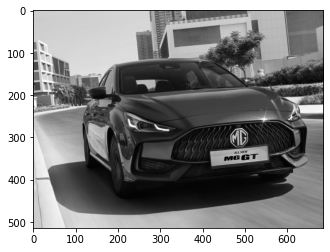

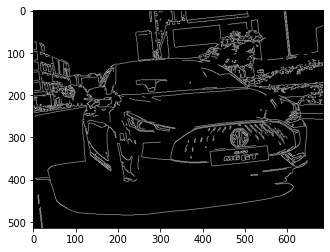

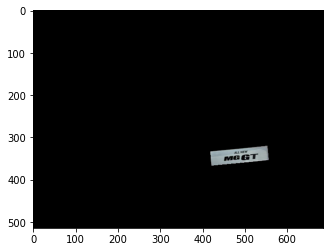

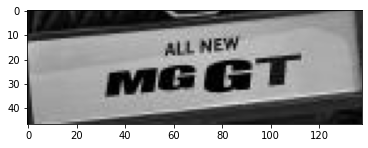

[([[270, 45], [446, 45], [446, 105], [270, 105]], 'ALL New', 0.30058947204639147), ([[152, 75], [580, 75], [580, 202], [152, 202]], 'MGgt', 0.2878955602645874)]
Car Text:    ALL New MGgt


In [98]:
import cv2
import matplotlib.pyplot as plt
import imutils
import easyocr

img = cv2.imread('Images/car_mg.jpg')
# img = cv2.imread('Images/car_arizo.jpg')    --> Can't get Plate in this image

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

# First we apply Bilateral Filter (To remove noise and enhance Edges)
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

# Then we apply Canny Edge Detection to enhance strong edges only
edged = cv2.Canny(bfilter, 120, 200)

plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.show()

# Getting Contours
key_points = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(key_points)

# Getting Larger 10 Contour Areas
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# To allocate the contour of the Plate
location = []
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 10, True)  # 10: Remove noise < 10 near the contour
    if len(approx) == 4:
        location.append(approx)
        break
        
# Apply Mask
mask = np.zeros(gray.shape, np.uint8)
for loc in location:
    mask = cv2.drawContours(mask, [loc], 0, (255,255,255), -1)
    
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

# Getting Locations of Plate
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))   # Top Left Corner
(x2, y2) = (np.max(x), np.max(y))   # Bottom Right Corner

# Cropping Plate
cropped_img = gray[x1 : x2+1, y1 : y2+1]
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.show()


# Resizing image to higher scale to improve accuracy
# This Resizing Get a lot better Scores on easyocr
scale_percent = 5
width =  int(cropped_img.shape[1] * scale_percent)
height = int(cropped_img.shape[0] * scale_percent)
output = cv2.resize(cropped_img, (width, height))


# Using OCR to read data 
reader = easyocr.Reader(['en'])
result = reader.readtext(output)
print(result)
car_text = "Car Text:   "
for res in result:
    car_text += " {}".format(res[-2])
print(car_text)


## Captcha Detecting using OCR

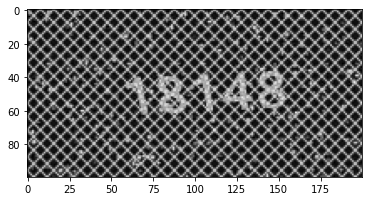

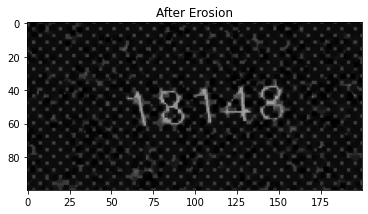

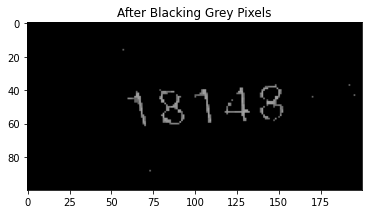

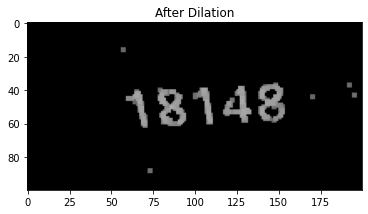

[([[274, 159], [793, 159], [793, 336], [274, 336]], '18148', 0.9999997867519373)]
Captcha:    18148


In [99]:
img = cv2.imread('Images/captcha.jpg', 0)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# To remove small white dot we make Erosion
kernel = np.ones((3,3), np.uint8)
erosion = cv2.erode(img, kernel, iterations=1)

plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
plt.title('After Erosion')
plt.show()

# Replace Grey Pixels to be Black
x,y = erosion.shape
for i in range(x):
    for j in range(y):
        if erosion[i,j] < 100:
            erosion[i,j] = 0
            
plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
plt.title("After Blacking Grey Pixels")
plt.show()

# Dilation to Enhance Shape of Letters
dilation = cv2.dilate(erosion, kernel, iterations=1)

plt.imshow(cv2.cvtColor(dilation, cv2.COLOR_BGR2RGB))
plt.title('After Dilation')
plt.show()

# Resizing image to higher scale to improve accuracy
scale_percent = 5
width =  int(dilation.shape[1] * scale_percent)
height = int(dilation.shape[0] * scale_percent)
output = cv2.resize(dilation, (width, height))


# Using OCR to read data 
reader = easyocr.Reader(['en'])
result = reader.readtext(output)
print(result)
car_text = "Captcha:   "
for res in result:
    car_text += " {}".format(res[-2])
print(car_text)


## Pytessract OCR to Read Books (Multiple Languages)
https://nanonets.com/blog/ocr-with-tesseract/

### Methods of pytesseract
- image_to_boxes ----------------------> put a box over each character
- image_to_data -----------------------> put a box over each word
- image_to_string ---------------------> convert to string
- image_to_pdf_or_hocr ----------------> convert to pdf

https://nanonets.com/blog/ocr-with-tesseract/

### Configurations
- 0    Orientation and script detection (OSD) only.
- 1    Automatic page segmentation with OSD.
- 2    Automatic page segmentation, but no OSD, or OCR.
- 3    Fully automatic page segmentation, but no OSD. (Default)
- 4    Assume a single column of text of variable sizes.
- 5    Assume a single uniform block of vertically aligned text.
- 6    Assume a single uniform block of text.
- 7    Treat the image as a single text line.
- 8    Treat the image as a single word.
- 9    Treat the image as a single word in a circle.
- 10    Treat the image as a single character.
- 11    Sparse text. Find as much text as possible in no particular order.
- 12    Sparse text with OSD.
- 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

To change your page segmentation mode, change the --psm argument in your custom config string to any of the above mentioned mode codes.

### Converting Image to text

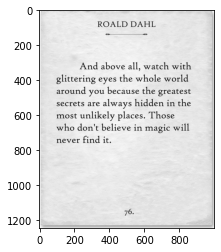

ROALD DAHL

And above all, watch with
glittering eyes the whole world
around you because the greatest
secrets are always hidden in the
most unlikely places. Those
who don't believe in magic will
never find it.

76.



In [108]:
import pytesseract

# Loading pytesseract Model
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Loading Book Page img
img = cv2.imread('Images/book_page.jpg')

# Convert to Gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Showing Images
plt.imshow(gray, 'gray')
plt.show()


# Apply pytesseract
config = "--psm 3"
text = pytesseract.image_to_string(gray, config=config)
print(text)


### Putting Boxes on each Word (image_to_data)

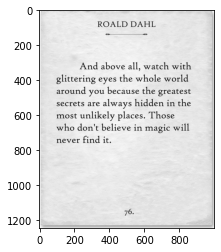

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


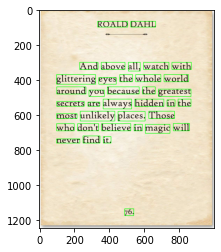

In [116]:
import pytesseract
from pytesseract import Output

# Loading pytesseract Model
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Loading Book Page img
img = cv2.imread('Images/book_page.jpg')

# Convert to Gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Showing Images
plt.imshow(gray, 'gray')
plt.show()


# Apply pytesseract
config = "--psm 3"
d = pytesseract.image_to_data(gray, config=config, output_type=Output.DICT)
print(d.keys())

# Drawing Boxes
n_boxes = len(d['text'])

for i in range(n_boxes):
    if float(d['conf'][i]) > 60:
        # print(d['text'])  # We can Regex on it
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


## Edge/Corner Detection (Feature Extraction)
- To match two images

### Harris Detection
- CONS: cant detect in different scale

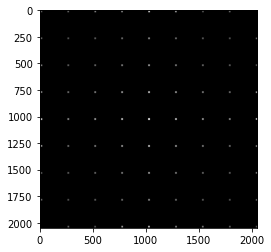

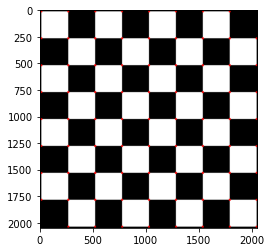

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('Images/chess.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Convert to float32 (To use Harris)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst,None, iterations=7)
plt.imshow(dst, 'gray')
plt.show()

# Detecting Strong Corners
img[dst > 0.01 * dst.max()] = [0, 0, 255]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


### Fast Algorithm to detect Corners (Interest Points)

Threshold: 10
Non-max Suppression: True
Neighborhood: 2
Total Keypoints with non-max-sup: 1448


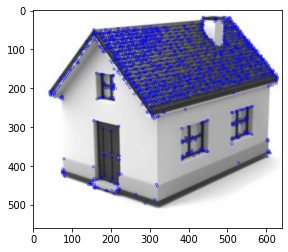

Threshold: 10
Non-max Suppression: False
Neighborhood: 2
Total Keypoints with max-sup: 7422


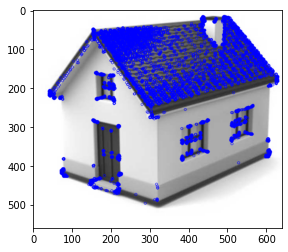

In [24]:
img = cv2.imread('Images/house.jpg', 0)

# Initiate Fast Algorithm
fast = cv2.FastFeatureDetector_create()

# Find and draw Keypoints
kp = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(0,0,255))

# Print default parameters
print("Threshold: {}".format(fast.getThreshold()))
print("Non-max Suppression: {}".format(fast.getNonmaxSuppression()))
print("Neighborhood: {}".format(fast.getType()))
print("Total Keypoints with non-max-sup: {}".format(len(kp)))

# Show img
plt.imshow(img2, 'gray')
plt.show()


# With Enabling Max Suppression (Getting weak and strong edges)
fast.setNonmaxSuppression(0)
kp = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(0,0,255))
# Print default parameters
print("Threshold: {}".format(fast.getThreshold()))
print("Non-max Suppression: {}".format(fast.getNonmaxSuppression()))
print("Neighborhood: {}".format(fast.getType()))
print("Total Keypoints with max-sup: {}".format(len(kp)))

# Show img
plt.imshow(img2, 'gray')
plt.show()

### SIFT Edge Detection (used for image Matching)
- Give Description for each point

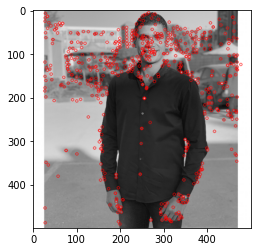

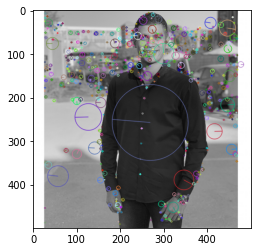

[[ 18.  39.  13. ...   0.   0.   0.]
 [  2.   0.   0. ...   0.   0.   1.]
 [  3.   3.   1. ...   0.   0.   0.]
 ...
 [  0.  20.  89. ...   0.   0.   2.]
 [  0.  13.  45. ...   0.   0.   0.]
 [  7.  28. 136. ...   0.   0.   0.]]


In [29]:
img = cv2.imread('Images/my_self.jpg')
img = cv2.resize(img, (500,500))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Initiate SIFT
sift = cv2.SIFT_create()

# Detect Keypoints and Draw them (default)
kp = sift.detect(gray)
img = cv2.drawKeypoints(gray, kp, None, color=(255,0,0))
plt.imshow(img, 'gray')
plt.show()

# SIFT with parameters to draw Magnitude and Orientation of each edge
img = cv2.drawKeypoints(gray, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img, 'gray')
plt.show()

# Getting Descriptor for each Pixel (for matching)
kp, des = sift.detectAndCompute(gray, None)
img = cv2.drawKeypoints(gray, kp, None, color=(255,0,0))
print(des)

#### Images Matching using SIFT

In [42]:
img1 = cv2.imread('Images/my_self.jpg', 0)
img2 = cv2.imread('Images/my_self_mob.jpg', 0)

# Initiate ORB
sift = cv2.SIFT_create()

# Getting KP and Descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
print(des2)

# Matching Points using FLANN KDTree
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm= FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Getting Strong Matches as Lowe's Paper
matchesMask = [[0,0] for i in range(len(matches))]
# Ratio Test
for i, (m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask= matchesMask, 
                   flags = cv2.DrawMatchesFlags_DEFAULT)

# Drawing Matchings
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

# Showing Image
# plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

[[  7. 109. 103. ...   0.   0.   0.]
 [  3.  66. 116. ...   0.   0.   0.]
 [  4.   0.   0. ...  16.   5.  13.]
 ...
 [121.  22.   0. ...   1.   0.   0.]
 [ 77.  25.   2. ...   0.   0.   0.]
 [  0.   0.   0. ...   1.  75. 132.]]


error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)


### ORB Algorithm and Matching Images
- Free algorithm to use

[[ 37 141 197 ... 234  64 168]
 [ 80 232 157 ...  16  66  42]
 [ 64  33  23 ... 128   3  35]
 ...
 [204  78 140 ... 248 189  11]
 [130 206  23 ...  89 169  14]
 [182 237 231 ... 255 240   0]]


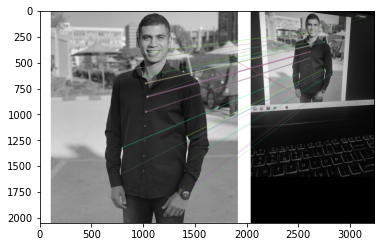

In [37]:
img1 = cv2.imread('Images/my_self.jpg', 0)
img2 = cv2.imread('Images/my_self_mob.jpg', 0)

# Initiate ORB
orb = cv2.ORB_create()

# Getting KP and Descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
print(des2)

# Matching Points using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Getting Strong Matches
matches = sorted(matches, key = lambda x:x.distance)

# Drawing Matchings
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

# Showing Image
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()